# Script to train model with data as tf.data



---
Link to the online version in Colab
https://colab.research.google.com/drive/1zjLocaTUN7IDvoatOSg1L6gU6WibxmDh?usp=sharing

---
The purpose of this notebook is to import images as tf.data format in order to accelerate processing and training

---
Link to Tensorflow Tutorial, taken as an example
https://www.tensorflow.org/tutorials/load_data/images



## 0. Constant variables

In [1]:
IMG_SIZE = 380
BATCH_SIZE = 64

## 1. Import


### 1.1. Mount Drive

In [2]:
# Mount drive
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Change your path HERE
path_project = 'drive/MyDrive/Yotta/projet_marmitoph'

os.chdir(path_project)
!ls

data  first_models  logs  models  notebooks  script_to_import_data.ipynb  src


### 1.2. Import Librairies

In [4]:
import os
import pathlib

import numpy as np
from random import randint
import matplotlib.pyplot as plt
import PIL
import pickle

import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalMaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.image import random_brightness, random_contrast, random_saturation, rot90, random_flip_left_right, random_flip_up_down

from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard

### 1.3. Import specific packages

In [5]:
dataset_url = "https://storage.googleapis.com/marmitoph_bucket/input_photos3bis.zip"

data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='blabla',
                                   archive_format='zip',
                                   extract=True
                                   )
#data_dir = pathlib.Path(data_dir)

1271078912/1271073119 [==============================] - 6s 0us/step


In [6]:
data_dir

'/root/.keras/datasets/blabla'

In [9]:
!ls /root/.keras/datasets/input_photos3/

 abricot			 miel
'aiguillettes de poulet'	 morbier
 ail				 moules
 amandes			'mousse au chocolat'
'amandes en poudre'		 moutarde
 ananas				 mozzarella
 anchois			 muesli
 aubergines			 mures
 avocat				 myrtilles
 banane				'noix de cajou'
 beurre				'noix de coco'
'beurres de cacahuetes'		 nouilles
 bieres				'nuggets de poulet'
 biscottes			 oeufs
 biscuits			'oignon blanc'
'blancs de poulet en tranches'	'oignon rouge'
 boudin				 oignons
'bouillon cube'			 olives
 brie				'olives noires'
 burrata			'olives vertes'
 cacahuetes			 oranges
 carottes			'pain de mie'
 cereales			 pains
 cerises			'pains d epices'
 chipolatas			 pamplemousse
 chorizo			 panettone
'chou fleur'			 parmesan
 citron				 pasteque
'citron vert'			'patate douce'
'compotes de pomme'		'pate brisee'
 comte				'pate de campagne'
 concombre			'pate feuilletee'
'confitures de fruits'		'pate sablee'
 cornichons			'pates de fruits'
 courgettes			'petits pois'
 cracottes			 poire
'cremes de marrons'		'pois chiches'
'cr

In [10]:
data_dir = pathlib.Path("/root/.keras/datasets/input_photos3/")

In [34]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

15724


## 2. Data

### 2.0. Examples

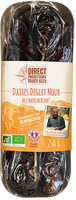

In [35]:
dattes = list(data_dir.glob('dattes/*'))
PIL.Image.open(str(dattes[9]))

### 2.1. Create an object tf.data
It contains the list of paths to the photos

In [36]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*.jpg'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [37]:
for f in list_ds.take(8):
  print(f.numpy())

b'/root/.keras/datasets/input_photos3/lentilles/83.jpg'
b'/root/.keras/datasets/input_photos3/aiguillettes de poulet/83.jpg'
b'/root/.keras/datasets/input_photos3/compotes de pomme/13.jpg'
b'/root/.keras/datasets/input_photos3/taboule/96.jpg'
b'/root/.keras/datasets/input_photos3/poire/9 - Copie (2).jpg'
b'/root/.keras/datasets/input_photos3/mousse au chocolat/35.jpg'
b'/root/.keras/datasets/input_photos3/patate douce/r_157_100.jpg'
b'/root/.keras/datasets/input_photos3/jambon sec/17.jpg'


### 2.2. Class names

In [38]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['abricot' 'aiguillettes de poulet' 'ail' 'amandes' 'amandes en poudre'
 'ananas' 'anchois' 'aubergines' 'avocat' 'banane' 'beurre'
 'beurres de cacahuetes' 'bieres' 'biscottes' 'biscuits'
 'blancs de poulet en tranches' 'boudin' 'bouillon cube' 'brie' 'burrata'
 'cacahuetes' 'carottes' 'cereales' 'cerises' 'chipolatas' 'chorizo'
 'chou fleur' 'citron' 'citron vert' 'compotes de pomme' 'comte'
 'concombre' 'confitures de fruits' 'cornichons' 'courgettes' 'cracottes'
 'cremes de marrons' 'cremes fraiches' 'cremes liquides' 'crevettes'
 'croutons' 'cuisses de poulet' 'dattes' 'emmental' 'emmental rape'
 'endives' 'epinards' 'escalopes de dinde' 'farine' 'figue'
 'filets de poulet' "flocons d'avoine" "fourme d'ambert" 'fraises'
 'framboises' 'fromage blanc' 'fruit de la passion' 'fruits secs'
 'gaufres' 'gingembre frais' 'gingembre moulu' 'glace' 'gnocchis' 'gouda'
 'goyave' 'grenade' 'gressins' 'haricots verts' 'harissa' 'houmous'
 "huile d'olive" 'huile de tournesol' 'jambon blanc' 'jam

In [39]:
NUM_CLASSES = len(class_names)
print(NUM_CLASSES)

181


In [40]:
# Create a dictionary
dict_num_to_label = {i:lab for i, lab in enumerate(class_names)}

In [41]:
print(dict_num_to_label)


{0: 'abricot', 1: 'aiguillettes de poulet', 2: 'ail', 3: 'amandes', 4: 'amandes en poudre', 5: 'ananas', 6: 'anchois', 7: 'aubergines', 8: 'avocat', 9: 'banane', 10: 'beurre', 11: 'beurres de cacahuetes', 12: 'bieres', 13: 'biscottes', 14: 'biscuits', 15: 'blancs de poulet en tranches', 16: 'boudin', 17: 'bouillon cube', 18: 'brie', 19: 'burrata', 20: 'cacahuetes', 21: 'carottes', 22: 'cereales', 23: 'cerises', 24: 'chipolatas', 25: 'chorizo', 26: 'chou fleur', 27: 'citron', 28: 'citron vert', 29: 'compotes de pomme', 30: 'comte', 31: 'concombre', 32: 'confitures de fruits', 33: 'cornichons', 34: 'courgettes', 35: 'cracottes', 36: 'cremes de marrons', 37: 'cremes fraiches', 38: 'cremes liquides', 39: 'crevettes', 40: 'croutons', 41: 'cuisses de poulet', 42: 'dattes', 43: 'emmental', 44: 'emmental rape', 45: 'endives', 46: 'epinards', 47: 'escalopes de dinde', 48: 'farine', 49: 'figue', 50: 'filets de poulet', 51: "flocons d'avoine", 52: "fourme d'ambert", 53: 'fraises', 54: 'framboises

### 2.3. Train Val Test Split


In [42]:
val_size = int(image_count * 0.1)
test_size = int(image_count * 0.1)

train_val_ds = list_ds.skip(test_size)
test_ds = list_ds.take(test_size)

train_ds = train_val_ds.skip(val_size)
val_ds = train_val_ds.take(val_size)

In [43]:
print(f"train ds: {len(train_ds)}")
print(f"val ds: {len(val_ds)}")
print(f"test ds: {len(test_ds)}")


train ds: 12580
val ds: 1572
test ds: 1572


In [44]:
# Alternative way to print size of datasets
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())
print(tf.data.experimental.cardinality(test_ds).numpy())

12580
1572
1572


### 2.4. Images Size

### 2.5. Functions
Functions to convert file path into pair (img, label)

In [45]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [ ]:
# Test
myfile_path = "~/.keras/datasets/input_photos/dattes/"
myparts = tf.strings.split(myfile_path, os.path.sep)
one_hot = myparts[-2] == class_names
tf.argmax(one_hot)

<tf.Tensor: shape=(), dtype=int64, numpy=65>

In [46]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [IMG_SIZE, IMG_SIZE])

In [47]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [48]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [49]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (380, 380, 3)
Label:  87


### 2.6. Data Augmentation

In [ ]:
def augment(img, label):
  img = tf.image.random_brightness(img, max_delta=0.5)
  #img = tf.image.random_contrast(img, lower=0.2, upper=0.5)
  #img = tf.image.random_saturation(img, lower=5, upper=10)
  img = tf.image.rot90(img, k=randint(0,3))
  img = tf.image.random_flip_left_right(img)
  img = tf.image.random_flip_up_down(img)
  
  return img, label

In [ ]:
train_ds = train_ds.map(augment)

### 2.7. Configure for performance
You can change BATCH SIZE here in the function if needed

In [50]:
def configure_for_performance(ds):
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(BATCH_SIZE) # YOU CAN CHANGE BATCH_SIZE HERE
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [51]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

### 2.8. Data visualisation



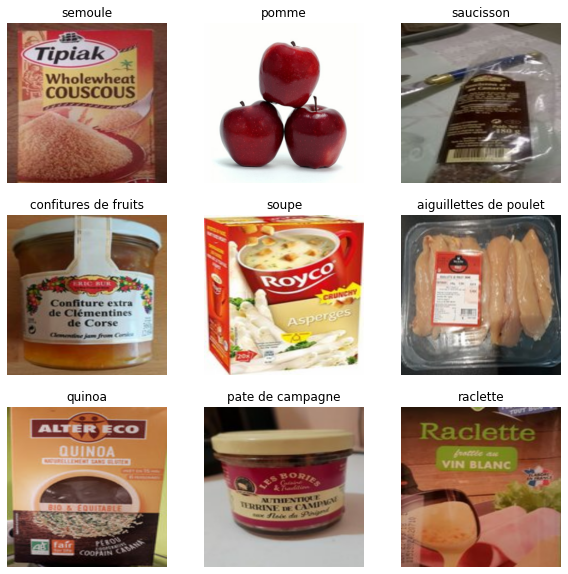

In [52]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

## 3. Model

### 3.1. Model building

In [54]:
def build_model(num_classes):

    base_model = EfficientNetB4(include_top=False, input_shape = (IMG_SIZE, IMG_SIZE, 3), weights="imagenet")

    # Freeze the pretrained weights
    base_model.trainable = False

    # Rebuild top
    x = GlobalMaxPooling2D()(base_model.output)
    x = Flatten()(x)
    x = BatchNormalization()(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.20)(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.20)(x)
    outputs = Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(base_model.input, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [55]:
model = build_model(num_classes=NUM_CLASSES)

71688192/71686520 [==============================] - 1s 0us/step


In [56]:
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 380, 380, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 380, 380, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 380, 380, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 381, 381, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

### 3.2. Callbacks

In [57]:
# Checkpoint callback
checkpoint_callback = ModelCheckpoint(filepath='logs', 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1,
                                      mode='auto'
                                      )
# CSV callback
csvlogger_callback = CSVLogger(filename='logs/log.csv', append=True)
# Tensorboard callback
tensorboard_callback = TensorBoard(log_dir='logs', histogram_freq=1)

# Callback list
callbacks_list = [checkpoint_callback, csvlogger_callback, tensorboard_callback]

### 3.3. Model training

In [58]:
# Train
with tf.device("gpu:0"):
  history = model.fit(
    x=train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks_list,
    verbose=1
  )

Epoch 1/30
197/197 [==============================] - 83s 331ms/step - loss: 5.0945 - accuracy: 0.0688 - val_loss: 3.5074 - val_accuracy: 0.3123

Epoch 00001: val_accuracy improved from -inf to 0.31234, saving model to logs
INFO:tensorflow:Assets written to: logs/assets
Epoch 2/30
197/197 [==============================] - 64s 313ms/step - loss: 3.4816 - accuracy: 0.2788 - val_loss: 2.8834 - val_accuracy: 0.3989

Epoch 00002: val_accuracy improved from 0.31234 to 0.39885, saving model to logs
INFO:tensorflow:Assets written to: logs/assets
Epoch 3/30
197/197 [==============================] - 64s 314ms/step - loss: 2.8532 - accuracy: 0.3859 - val_loss: 2.5302 - val_accuracy: 0.4555

Epoch 00003: val_accuracy improved from 0.39885 to 0.45547, saving model to logs
INFO:tensorflow:Assets written to: logs/assets
Epoch 4/30
197/197 [==============================] - 64s 314ms/step - loss: 2.4729 - accuracy: 0.4572 - val_loss: 2.2966 - val_accuracy: 0.4943

Epoch 00004: val_accuracy improved 

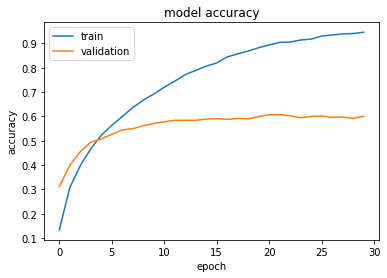

In [59]:
# Plotting

import matplotlib.pyplot as plt

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    
plot_hist(history)

#### Saving pretrained model

In [60]:
# Saving pretrained model
model.save('model_pretrained.h5')

In [61]:
# Export to pickle
model_dict = {'dict_num_to_label':dict_num_to_label,
              'model_pretrained':model,
              }

with open('models/mymodel.pickle', 'wb') as handle:
    pickle.dump(model_dict, handle)

RecursionError: ignored

### 3.4. Model fine-tuning

In [64]:
# Unfreeze layers
def unfreeze_model(model, n_layers=0):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    if n_layers != 0:
      for layer in model.layers[-n_layers:]:
          if not isinstance(layer, BatchNormalization):
              layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )


In [65]:
unfreeze_model(model, n_layers=40)

In [66]:
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 380, 380, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 380, 380, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 380, 380, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 381, 381, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [67]:
# Fine-Tuning

#UNFREEZE LAYERS FOR FINE TUNING
#===============================
# Done
#===============================

with tf.device("gpu:0"):
  history = model.fit(
    x=train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks_list,
    verbose=1
  )

Epoch 1/10
197/197 [==============================] - 87s 371ms/step - loss: 0.2174 - accuracy: 0.9483 - val_loss: 1.7371 - val_accuracy: 0.6126

Epoch 00001: val_accuracy improved from 0.60751 to 0.61260, saving model to logs
INFO:tensorflow:Assets written to: logs/assets
Epoch 2/10
197/197 [==============================] - 71s 347ms/step - loss: 0.1822 - accuracy: 0.9588 - val_loss: 1.7296 - val_accuracy: 0.6113

Epoch 00002: val_accuracy did not improve from 0.61260
Epoch 3/10
197/197 [==============================] - 70s 346ms/step - loss: 0.1820 - accuracy: 0.9579 - val_loss: 1.7221 - val_accuracy: 0.6126

Epoch 00003: val_accuracy did not improve from 0.61260
Epoch 4/10
197/197 [==============================] - 71s 347ms/step - loss: 0.1750 - accuracy: 0.9602 - val_loss: 1.7159 - val_accuracy: 0.6132

Epoch 00004: val_accuracy improved from 0.61260 to 0.61323, saving model to logs
INFO:tensorflow:Assets written to: logs/assets
Epoch 5/10
197/197 [==============================

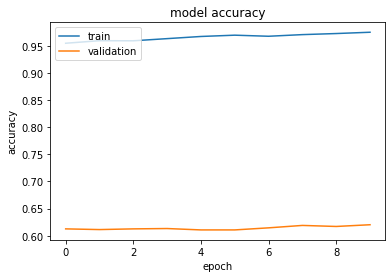

In [68]:
# Plotting
plot_hist(history)

In [69]:
# Saving pretrained model
model.save('model_finetuned.h5')

In [70]:
# Export to pickle
label_dict = {'dict_num_to_label':dict_num_to_label}

with open('label_dict.pickle', 'wb') as handle:
    pickle.dump(label_dict, handle)

## 4. Evaluation

## Load Model from public GCP bucket


In [13]:
from tensorflow.python.lib.io import file_io
from keras.models import load_model

url = 'gs://marmitoph_bucket/model/model_finetuned.h5'

model_file = file_io.FileIO(url, mode='rb')

# Temp opening file
temp_model_location = './temp_model.h5'
temp_model_file = open(temp_model_location, 'wb')
temp_model_file.write(model_file.read())
temp_model_file.close()
model_file.close()

# Load model
model = load_model(temp_model_location)